In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import category_encoders as ce
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import re
import os
sns.set_theme(style="darkgrid")

path = os.path.dirname(os.getcwd()).replace('\\', '/') + '/'


import warnings
warnings.simplefilter("ignore", UserWarning)

warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)

In [2]:
hotels_data = pd.read_csv(path + 'data_set\hotels.csv')

# Подсчитываем количество дубликатов и удаляем их 
print(f'Количество дубликатов составляет: {hotels_data.duplicated().sum()}')
hotels_data.drop_duplicates()



Количество дубликатов составляет: 307


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.8,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.2,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.3,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.2,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066


In [3]:
hotels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

# Кодирование категориальных признаков


## Кодирование страны, в которой расположен отель

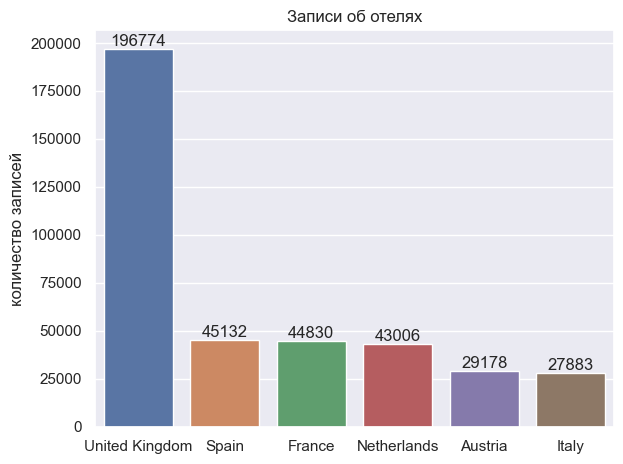

In [4]:
# Записываем категориальные признаки в отдельный датафрейм
ObjDataHotel = hotels_data[['hotel_address', 'hotel_name', 
                            'reviewer_nationality', 'negative_review', 
                            'positive_review', 'tags']]


# Из признака 'hotel_address' мы можем извлечь название страны
ObjDataHotel['hotel_country'] = \
    ObjDataHotel['hotel_address'].apply(lambda x: x.split(' ')[-2:]) 
    
    
    
ObjDataHotel['hotel_country'] = \
    ObjDataHotel['hotel_country'].apply(lambda x: x[1] if x[0] != 'United' and \
        x[1] != 'Kingdom' else 'United Kingdom')
    
# Судя по всему в датафрейме указаны только столичные отели, поэтому 
# извлекать название города в отдельную переменную нет необходимости    
    
    
# Подсчитываем количество записей об отелях по странам и выводим ввиде барплота
HotelCntry_count = ObjDataHotel['hotel_country'].value_counts().to_frame()

HotelCntry_count.reset_index().rename(columns={'hotel_country':'hotel_country'})

HotelCntry_bar = sns.barplot(data=HotelCntry_count, x='hotel_country', 
                             y='count', hue='hotel_country', palette='deep',
                             errorbar=None)

HotelCntry_bar.set(title='Записи об отелях', 
                   ylabel='количество записей', xlabel='')


for i in HotelCntry_bar.containers:
    HotelCntry_bar.bar_label(i)
    
plt.tight_layout()


Признак отражающий страну, в которой расположен отель, нам потребуется в дальнейшем, чтобы более точно <br>
заполнить пропуски в признаках lat (широта) и lng (долгота). После заполнения пропусков, его можно будет удалить т. к. <br>
вышеназванные широта и долгота его дублируют.

## Кодирование признаков, отражающих названия отеля,<br> национальности рецензента

In [5]:
# Оцениваем количество уникальных значений в признаке 'hotel_name'
print(f"Количество уникальных значений \
hotel_name {ObjDataHotel['hotel_name'].nunique()}")

print(f"Количество уникальных значений \
reviewer_nationality {ObjDataHotel['reviewer_nationality'].nunique()}")


# Кодируем эту переменную с помощью Binary Encoder 
# так как уникальных значений значительно выше 15
BinEncoder = ce.BinaryEncoder(cols=['hotel_name'])
BinHotlname = BinEncoder.fit_transform(ObjDataHotel['hotel_name'])
BinHotlname


# Аналогичным образом можно закодировать 'reviewer_nationality'
BinEncoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
BinRewNation = BinEncoder.fit_transform(ObjDataHotel['reviewer_nationality'])
BinRewNation

Количество уникальных значений hotel_name 1492
Количество уникальных значений reviewer_nationality 225


,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...
386798,0,0,0,0,0,1,0,0
386799,0,0,1,0,1,0,1,1
386800,0,0,0,0,1,1,1,1
386801,0,0,0,0,1,0,0,0


## Кодирование негативных и позитиных комментариев

### Negative review

In [6]:
# Приводим все строки в переменной 'negative_review' к нижнему регистру
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: x.lower())

# Выбираем топ 150 коментариев, среди которых ложно-отрицательные
# (по типу "No negative" или "nothing") будут всречаться наиболее часто
NonNegList = ObjDataHotel['negative_review'].value_counts()\
    .nlargest(150).to_frame().reset_index()



# Среди этого топа комментариев выбираем ключевые слова, которые ассоциированы
# с истинно-отрицательными комментариями по типу "bad wifi" 
to_find = r'nois|room|leav|pric|bed|cost|applicable|parking|gym|^.*wifi$|staff|\
    |breakfast|bathroom|everything|pool|bar|view|service|location|expensive|\
        |cleanliness|weather|pillows'

# Функция возвращает None если слово в списке to_find, 
# в противном случае возвращает строку без изменений
def FindRegEx (string):
    findlst = re.findall(to_find, string)
    if len(findlst) > 0:
        return
    else:
        return string


NonNegList['negative_review'] = \
    NonNegList['negative_review'].apply(lambda x: ''.join(x.split(' ')))

NonNegList['negative_review'] = \
    NonNegList['negative_review'].apply(FindRegEx)
    
    
# Удаляем None и оставляем только уникальные значения
NonNegList.dropna(inplace=True)
NonNegList = list(set(NonNegList['negative_review']))



# Удаляем пробеды из признака 'negative_review'
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: ''.join(x.split(' ')))
    

# Заменяем ложно-негативные на 0, истинно негативные на 1
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: 0 if x in NonNegList else 1)
    
NegRewMod = ObjDataHotel['negative_review'].to_frame()

### Positive review

In [7]:
# Аналогичны образом можно модифицировать признак 'positive_review'

# Приводим все строки в переменной 'negative_review' к нижнему регистру
ObjDataHotel['positive_review'] = \
    ObjDataHotel['positive_review'].apply(lambda x: x.lower())

# Выбираем топ 150 коментариев, среди которых ложно-отрицательные
# (по типу "No negative" или "nothing") будут всречаться наиболее часто
NonPosList = ObjDataHotel['positive_review'].value_counts()\
    .nlargest(150).to_frame().reset_index()
    


# Среди этого топа комментариев выбираем ключевые слова, которые ассоциированы
# с ложно-положительными комментариями по типу "nothing" 
to_find = r'^na|^no'


# Функция возвращает строку если слово в списке to_find, 
# в противном случае возвращает None
def FindRegEx (string):
    findlst = re.findall(to_find, string)
    if len(findlst) > 0 or string == '':
        return string
    else:
        return 
    
    
NonPosList['positive_review'] = \
    NonPosList['positive_review'].apply(lambda x: ''.join(x.split(' ')))

NonPosList['positive_review'] = \
    NonPosList['positive_review'].apply(FindRegEx)
    
    
# Удаляем None и оставляем только уникальные значения
NonPosList.dropna(inplace=True)
NonPosList = list(set(NonPosList['positive_review']))



# Удаляем пробеды из признака 'positive_review'
ObjDataHotel['positive_review'] = \
    ObjDataHotel['positive_review'].apply(lambda x: ''.join(x.split(' ')))
    

# Заменяем ложно-негативные на 0, истинно негативные на 1
ObjDataHotel['positive_review'] = \
    ObjDataHotel['positive_review'].apply(lambda x: 0 if x in NonPosList else 1)
    
PosRewMod = ObjDataHotel['positive_review'].to_frame()

### Выводим результат в виде барплотов

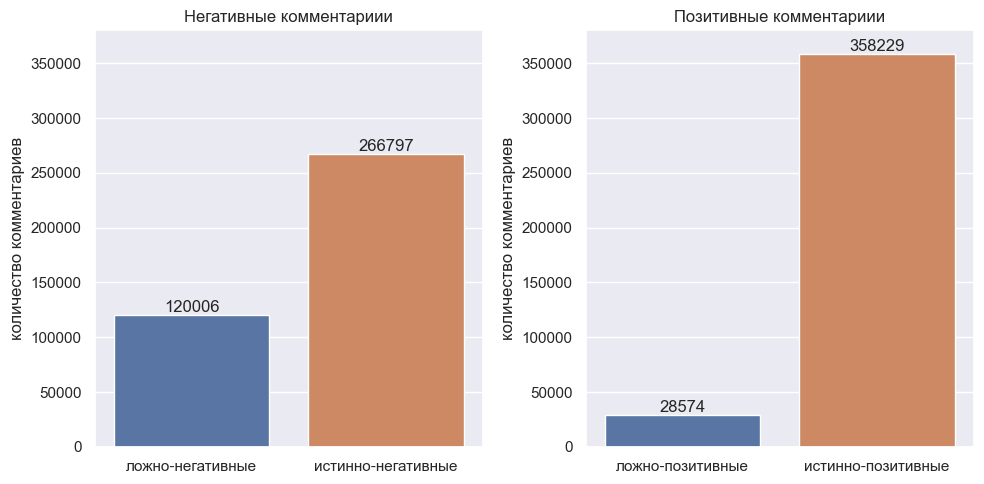

In [8]:
# Выводим в виде барплотов
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
 
    
# Барплот с негативными комментариями   
NegCom_count = ObjDataHotel['negative_review'].value_counts().to_frame()
NegCom_count.reset_index()
NegCom_count_bar = sns.barplot(data=NegCom_count, x='negative_review', ax=ax[0],
                             y='count', hue='negative_review', palette='deep',
                             errorbar=None, legend=False)

NegCom_count_bar.set(title='Негативные комментариии', 
                   ylabel='количество комментариев', xlabel='',
                   xticklabels=['ложно-негативные', 'истинно-негативные'],
                   ylim=(0, 380000))


for i in NegCom_count_bar.containers:
    NegCom_count_bar.bar_label(i)
################################################################################    


# Барплот с позитивными комментариями
PosCom_count = ObjDataHotel['positive_review'].value_counts().to_frame()
PosCom_count.reset_index()
PosCom_count_bar = sns.barplot(data=PosCom_count, x='positive_review', ax=ax[1],
                             y='count', hue='positive_review', palette='deep',
                             errorbar=None, legend=False)

PosCom_count_bar.set(title='Позитивные комментариии', 
                   ylabel='количество комментариев', xlabel='',
                   xticklabels=['ложно-позитивные', 'истинно-позитивные'],
                   ylim=(0, 380000))

for i in PosCom_count_bar.containers:
    PosCom_count_bar.bar_label(i)
################################################################################   



fig.tight_layout()

## Извлекаем дополнительные признаки из признака 'tags'

In [9]:
TagData = ObjDataHotel['tags'].to_frame()

# Превращаем строки в списки
TagData['tags'] = \
    TagData['tags'].apply(lambda x: re.sub(r"[\[\] ']", '', x).lower().split(','))


# Создаем признаки которые отражают тип поездки
TagData['leisure_trip'] = \
    TagData['tags'].apply(lambda x: 1 if 'leisuretrip' in x else 0)
    
TagData['business_trip'] = \
    TagData['tags'].apply(lambda x: 1 if 'businesstrip' in x else 0)


# Способ бронирования
TagData['mobile_submit'] = \
    TagData['tags'].apply(lambda x: 1 if 'submittedfromamobiledevice' in x else 0)


# Количества постояльцев 
TagData['solo_traveler'] = \
    TagData['tags'].apply(lambda x: 1 if 'solotraveler' in x else 0)
    
TagData['couple'] = \
    TagData['tags'].apply(lambda x: 1 if 'couple' in x else 0)
    
TagData['group'] = \
    TagData['tags'].apply(lambda x: 1 if 'group' in x else 0)


# С детьми 
TagData['family_with_young_children'] =\
    TagData['tags'].apply(lambda x: 1 if 'familywithyoungchildren' in x else 0)
    
TagData['family_with_older_children'] =\
    TagData['tags'].apply(lambda x: 1 if 'familywitholderchildren' in x else 0)


# Количество ночей
TagData['NightsCnt'] = \
    TagData['tags'].apply(lambda x: x[-1] if x[-1].startswith('stayed') else 0)

# В получившемся признаке оставляем только цифры 
TagData['NightsCnt'] = \
    TagData['NightsCnt'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]))


In [10]:
# Функция удаляет все теги из 'tags'
def tag_remover(tag_lst):
    
    tag_to_remove = ['leisuretrip', 'businesstrip', 'submittedfromamobiledevice', 
                     'solotraveler', 'couple', 'group', 'familywithyoungchildren', 
                     'familywitholderchildren']
    
    # В tag_lst остается только те теги которого нету в списке tag_to_remove
    tag_lst = [i for i in tag_lst if i not in tag_to_remove]
    
    # Оставляем только те теги которые не соответсвуют regex
    regex = re.compile(r'^stayed.*$') 
    tag_lst = [j for j in tag_lst if not regex.match(j)] 
    
    # Возвращаем None если tag_lst пустой, иначе возвращаем 1-ый элемент
    return None if len(tag_lst) < 1 else tag_lst[0]
################################################################################


# Применяем функцию к списку тегов
TagData['tags'] = TagData['tags'].apply(tag_remover)

# Заполняем None модальным значением
TagData['tags'] = TagData['tags'].fillna(TagData['tags'].mode()[0])

# Переименовываем 'tags' в 'room_type'
TagData = TagData.rename(columns={'tags':'room_type'})



# Кодируем 'room_type' с помощью BinaryEncoder из-за большого числа уникальных значений
BinEncoder = ce.BinaryEncoder(cols='room_type')

TagBin = BinEncoder.fit_transform(TagData['room_type'])
TagData = pd.concat([TagData, TagBin], axis=1)


# Удаляем 'room_type' из tag_data
TagDataEncoded = TagData.drop('room_type', axis=1)

In [11]:

TagDataEncoded

,leisure_trip,business_trip,mobile_submit,solo_traveler,couple,group,family_with_young_children,family_with_older_children,NightsCnt,room_type_0,...,room_type_2,room_type_3,room_type_4,room_type_5,room_type_6,room_type_7,room_type_8,room_type_9,room_type_10,room_type_11
0,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,1,0,0,0,6,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,1,0,1,0,0,1,0,0,0,0,...,0,1,0,0,1,1,1,0,1,1
386799,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
386800,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,1,1,0,1,1,0
386801,1,0,0,1,0,0,0,0,2,0,...,0,0,0,0,1,1,0,0,1,0


## Кодируем признаки, извлеченные из tags

## Заполнение NaN в признаках широты и долготы

In [12]:
# В отдельный датафрейм выделяем название страны а также широту и долготу отеля
HotelLngLat = hotels_data[['lat', 'lng']]
HotelLngLat['country'] = ObjDataHotel['hotel_country']


# Создаем список стран
country_lst = HotelLngLat['country'].value_counts().index.tolist()

# Создаем пустой датафрейм
InitialDf = pd.DataFrame()

# Инициализируем цикл for который будет заполнять na модальным в соответсвии со страной
for i in country_lst:
    
    # Создаем сабсет данных 
    subset = HotelLngLat[HotelLngLat['country'] == i]

    
    # Определяем моду по широте (lat) и заполняем ею значения na
    lat_mode_val = subset['lat'].mode()[0]
    subset['lat'] = subset['lat'].fillna(lat_mode_val)


    # Создаем соответсвующий этой широте список долгот (lng) и 
    # выбираем самое часто встречаемое значение [0]
    ModeMask = subset['lat'] == lat_mode_val
    lng_mode_val = subset[ModeMask].lng.value_counts().index[0]


    # Заполняем этим значением na в признаке долгота (lng)
    subset['lng'] = subset['lng'].fillna(lng_mode_val)

    
    # Присоединяем к InitialDf и сортируем по индексам
    InitialDf = pd.concat([InitialDf, subset], axis=0).sort_index()


# InitialDf == HotelLngLat

InitialDf = InitialDf.drop('country', axis=1)
InitialDf

,lat,lng
0,51.507894,-0.143671
1,51.521009,-0.123097
2,48.845377,2.325643
3,48.888697,2.394540
4,52.385601,4.847060
...,...,...
386798,51.494028,-0.191050
386799,48.192379,16.399451
386800,51.520795,-0.131084
386801,51.515125,-0.160066


## Обединяем все получнные данные в единый датафрейм

In [13]:
# Обединяем все в один финальный датафрейм с закодированными переменными
ObjDataHotel_encoded = pd.concat([ObjDataHotel,
                                  TagDataEncoded,
                                  BinHotlname,
                                  BinRewNation], axis=1)
# Удаляем ненужные столбцы
ObjDataHotel_encoded =\
    ObjDataHotel_encoded.drop(['hotel_address', 'hotel_name',
                                'reviewer_nationality',
                               'tags', 'hotel_country'], axis=1)
    
ObjDataHotel_encoded

,negative_review,positive_review,leisure_trip,business_trip,mobile_submit,solo_traveler,couple,group,family_with_young_children,family_with_older_children,...,hotel_name_9,hotel_name_10,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,1,1,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1,1,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,1,0,1,0,1,1,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
3,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,0,1,1,0,1,0,0,1,0,0,...,1,1,0,0,0,0,0,1,0,0
386799,0,1,1,0,1,0,1,0,0,0,...,1,1,0,0,1,0,1,0,1,1
386800,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
386801,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Определяем какие категориальные  признаки наиболее важны в определении рейтинга отеля

In [14]:
country_dummies = pd.get_dummies(ObjDataHotel['hotel_country'], dtype=int)

ObjDataHotel_encoded = pd.concat([ObjDataHotel_encoded, country_dummies], axis=1)
ObjDataHotel_encoded

,negative_review,positive_review,leisure_trip,business_trip,mobile_submit,solo_traveler,couple,group,family_with_young_children,family_with_older_children,...,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,Austria,France,Italy,Netherlands,Spain,United Kingdom
0,1,1,1,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,1,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1,0,1,0,1,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,1,1,0,1,0,0,1,0,0,0,...,0,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,0,1,1,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
386799,0,1,1,0,1,0,1,0,0,0,...,1,0,1,1,1,0,0,0,0,0
386800,1,1,0,1,0,1,0,0,0,0,...,1,1,1,1,0,0,0,0,0,1
386801,0,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


,negative_review,business_trip,NightsCnt,positive_review,solo_traveler,reviewer_nationality_6,reviewer_nationality_3,leisure_trip,couple,mobile_submit,reviewer_nationality_2,United Kingdom,Spain,Austria,room_type_5
0,1,0,0,1,0,0,0,1,1,1,0,1,0,0,0
1,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0
2,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0
3,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0
4,1,1,6,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0
386799,0,0,0,1,0,1,0,1,1,1,1,0,0,1,0
386800,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0
386801,0,0,2,1,1,0,0,1,0,0,0,1,0,0,0


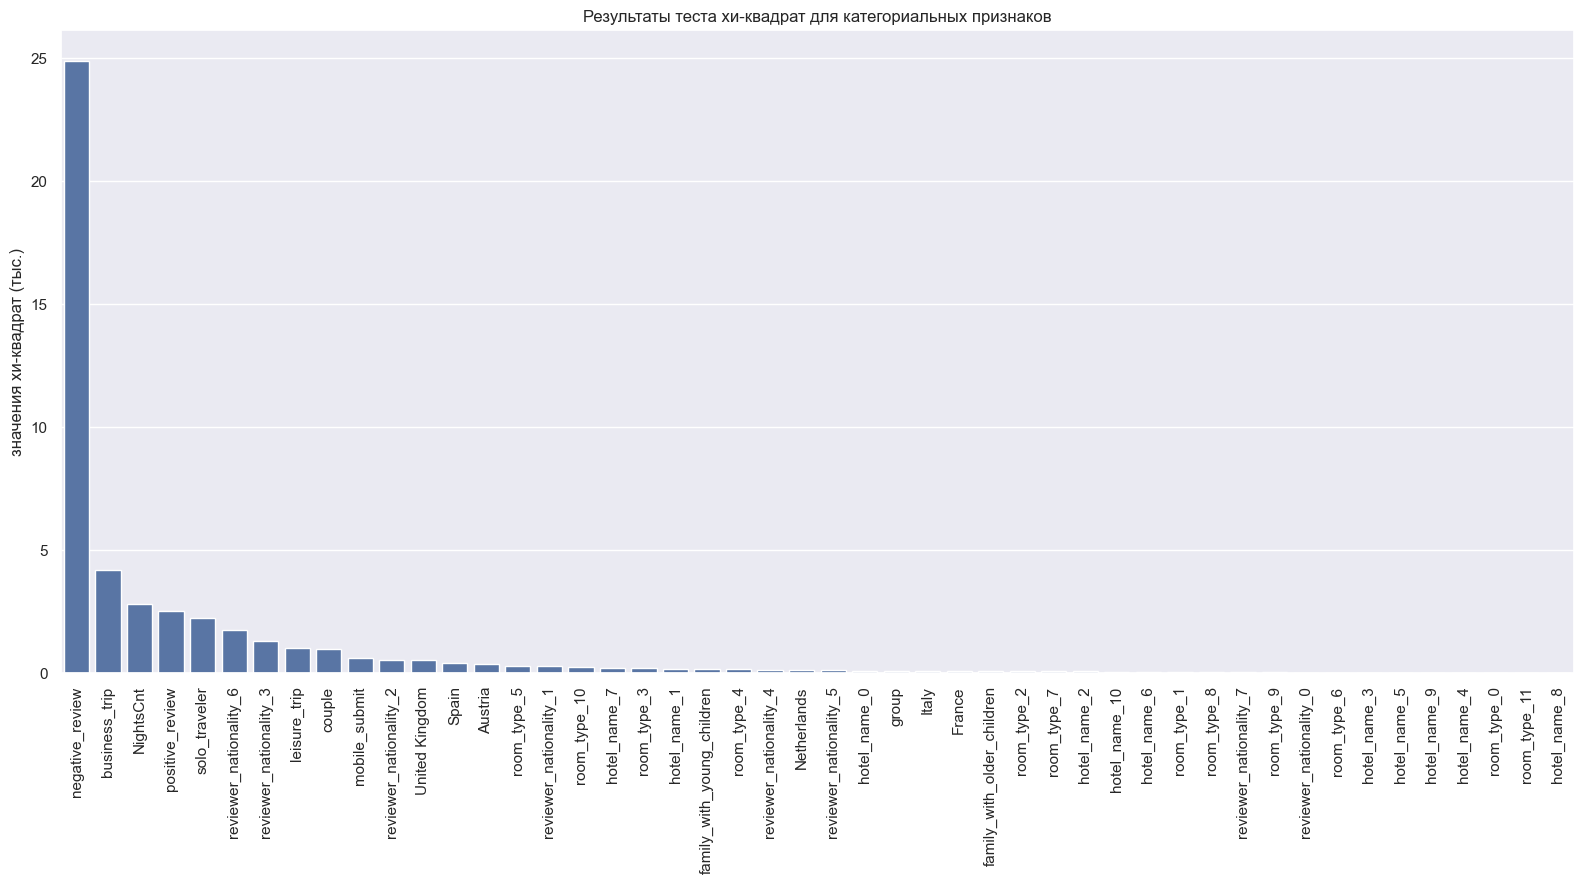

In [15]:
from sklearn.feature_selection import chi2 # хи-квадрат


# В у записываем определяемую пременную
y = hotels_data['reviewer_score'].astype('int')


# Оцениваем взаимосвязь с помощью критерия хи-квадрат
imp_cat = pd.Series(chi2(ObjDataHotel_encoded, y)[0], 
                    index=list(ObjDataHotel_encoded))

imp_cat.sort_values(ascending=False, inplace = True)

# Отображаем в виде барплота
fig, ax = plt.subplots( figsize=(16, 9))

BarPl = sns.barplot(x=imp_cat.index, 
                    y=imp_cat.values/1000, 
                    ax=ax)

BarPl.set(title='Результаты теста хи-квадрат для категориальных признаков',
          xlabel='', ylabel='значения хи-квадрат (тыс.)' )

plt.xticks(rotation=90)

fig.tight_layout()
fig.show()


# Выбираем топ 15 признаков
CatLst = imp_cat.nlargest(15).index.tolist()

ObjDataHotel_final = ObjDataHotel_encoded[CatLst]
ObjDataHotel_final

# Преобразование числовых переменных

In [16]:

# Извлекаем информацию из даты
DateOfReview = pd.to_datetime(hotels_data['review_date']).to_frame()

# День года
DateOfReview['day_of_year'] = DateOfReview['review_date'].dt.day_of_year

# Месяц года
DateOfReview['month'] = DateOfReview['review_date'].dt.month

# Квартал
DateOfReview['quarter'] = DateOfReview['review_date'].dt.quarter

# День недели
DateOfReview['weekday'] = DateOfReview['review_date'].dt.weekday

# Год
DateOfReview['year'] = DateOfReview['review_date'].dt.year


# Удаляем признак 'review_date'
DateOfReview = DateOfReview.drop('review_date', axis=1)

In [17]:
# Выделяем столбцы с числовыми переменными в отдельный датафрейм
NumDataHotel = hotels_data.drop(['hotel_address', 'hotel_name', 'lat', 'lng',
                            'reviewer_nationality', 'negative_review', 'review_date',
                            'positive_review', 'tags', 'reviewer_score'], axis=1)

NumDataHotel['days_since_review'] =\
    NumDataHotel['days_since_review'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

NumDataHotel = pd.concat([NumDataHotel, InitialDf, DateOfReview], axis=1)
NumDataHotel

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,day_of_year,month,quarter,weekday,year
0,581,8.4,3,1994,4,7,531,51.507894,-0.143671,50,2,1,4,2016
1,299,8.3,3,1361,2,14,203,51.521009,-0.123097,12,1,1,3,2017
2,32,8.9,6,406,0,14,289,48.845377,2.325643,292,10,4,1,2016
3,34,7.5,0,607,11,8,681,48.888697,2.394540,265,9,3,1,2015
4,914,8.5,4,7586,20,10,516,52.385601,4.847060,65,3,1,5,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,107,9.0,0,617,10,10,106,51.494028,-0.191050,109,4,2,2,2017
386799,272,8.4,0,3224,93,1,171,48.192379,16.399451,44,2,1,0,2017
386800,457,6.8,12,2751,9,21,543,51.520795,-0.131084,38,2,1,6,2016
386801,365,8.1,0,1567,6,28,74,51.515125,-0.160066,141,5,2,6,2017


## Модифицируем числовые переменные с помощью RobustScaler/StandartScaler

In [ ]:
def Scaler(DataFrame, Feature, alpha=0.05):
    """ Функция на вход принимает признак и возвращает его либо
    нормализованный, либо стандартизованный вариант. Если распредленеие
    признака нормальное применяется стандартизация с помощью Standart Scaler.
    Если распределение не нормальное, то применяется нормальзация с 
    использованием Robust Scaler. Оценка нормальности осуществляется с помощью 
    теста Колмогорова-Смирнова 
    
    Args:
        DataFrame (pd.DataFrame): датафрейм из которого берется признак
        Feature (str): признак, который будет приобразован
        alpha (float, optional): пороговый уровень alpha относительно готорого 
                                 мы оцениваем нормальность распределения. 
                                 Defaults to 0.05.

    Returns:
        pd.Series: Возвращает преобразованный признак в формате pd.Series
    """
    
    # Проверяем признак на нормальность распределения
    Kol_Smrnf_P = stats.kstest(DataFrame[Feature], 'norm', 
                             args=(DataFrame[Feature].mean(), 
                                   DataFrame[Feature].std())).pvalue
    
    # Если распределение не нормальное преобразуем данные по методу yeo-johnson
    # затем применяем применяем Robust Scaler
    if Kol_Smrnf_P < alpha:
        print(f'{Feature} KS P-value < {alpha}. Применяю RobustScaler')
        
        
        pt_yeo_johnson = PowerTransformer(method='yeo-johnson')
        RobustSclr = RobustScaler()
        
        data_mod = pt_yeo_johnson.fit_transform(DataFrame[Feature].to_frame())
        data_mod = RobustSclr.fit_transform(DataFrame[Feature].to_frame())
        
        # преобразуем выдачу RobustScaler в pd.Series
        data_mod = [i[0] for i in data_mod]
        data_mod = pd.Series(data_mod, name=Feature)
       
        
        # Возвращаем модифицированный признак
        return data_mod
    
    
    # Если распределение нормальное применяем Standard Scaler
    else: 
        print(f'{Feature} KS P-value > {alpha}. Применяю StandardScaler')
        
        StandardSclr = StandardScaler()
        data_mod = StandardSclr.fit_transform(DataFrame[Feature].to_frame())
        
        # преобразуем выдачу RobustScaler в pd.Series
        data_mod = [i[0] for i in data_mod]
        data_mod = pd.Series(data_mod, name=Feature)
        
        # Возвращаем модифицированный признак
        return data_mod

In [19]:
# С помощью функции Scaler преобразуем признаки и записваем их в формате pd.Series 
# 'total_number_of_reviews 
TNOR_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='total_number_of_reviews')


# 'review_total_positive_word_counts
RTPWC_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='review_total_positive_word_counts')

# 'review_total_negative_word_counts
RTNWC_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='review_total_negative_word_counts')    
    
#'total_number_of_reviews_reviewer_has_given
TNORRHG_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='total_number_of_reviews_reviewer_has_given')

# 'average_score'
AS_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='average_score')

# 'additional_number_of_scoring'
ANOS_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='additional_number_of_scoring')

# 'days_since_review
DSR_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='days_since_review')

Lat_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='lat')

Lng_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='lng')

DOY_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='day_of_year')

Month_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='month')

Quarter_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='quarter')

Weekday_rs = Scaler(DataFrame=NumDataHotel,
                 Feature='weekday')




total_number_of_reviews KS P-value < 0.05. Применяю RobustScaler
review_total_positive_word_counts KS P-value < 0.05. Применяю RobustScaler
review_total_negative_word_counts KS P-value < 0.05. Применяю RobustScaler
total_number_of_reviews_reviewer_has_given KS P-value < 0.05. Применяю RobustScaler
average_score KS P-value < 0.05. Применяю RobustScaler
additional_number_of_scoring KS P-value < 0.05. Применяю RobustScaler
days_since_review KS P-value < 0.05. Применяю RobustScaler
lat KS P-value < 0.05. Применяю RobustScaler
lng KS P-value < 0.05. Применяю RobustScaler
day_of_year KS P-value < 0.05. Применяю RobustScaler
month KS P-value < 0.05. Применяю RobustScaler
quarter KS P-value < 0.05. Применяю RobustScaler
weekday KS P-value < 0.05. Применяю RobustScaler


In [20]:
year_dummie = pd.get_dummies(NumDataHotel['year'], dtype=int, prefix='year')
year_dummie

,year_2015,year_2016,year_2017
0,0,1,0
1,0,0,1
2,0,1,0
3,1,0,0
4,0,1,0
...,...,...,...
386798,0,0,1
386799,0,0,1
386800,0,1,0
386801,0,0,1


In [21]:
NumDataHotel_mod = pd.concat([ANOS_rs, RTNWC_rs, TNOR_rs, RTPWC_rs, 
                              TNORRHG_rs, AS_rs, DSR_rs, Lat_rs, Lng_rs,
                              DOY_rs, Month_rs, Quarter_rs, Weekday_rs], 
                             axis=1)
NumDataHotel_mod

,additional_number_of_scoring,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,average_score,days_since_review,lat,lng,day_of_year,month,quarter,weekday
0,581,3,1994,4,7,8.4,531,51.507894,-0.143671,50,2,1,4
1,299,3,1361,2,14,8.3,203,51.521009,-0.123097,12,1,1,3
2,32,6,406,0,14,8.9,289,48.845377,2.325643,292,10,4,1
3,34,0,607,11,8,7.5,681,48.888697,2.394540,265,9,3,1
4,914,4,7586,20,10,8.5,516,52.385601,4.847060,65,3,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,107,0,617,10,10,9.0,106,51.494028,-0.191050,109,4,2,2
386799,272,0,3224,93,1,8.4,171,48.192379,16.399451,44,2,1,0
386800,457,12,2751,9,21,6.8,543,51.520795,-0.131084,38,2,1,6
386801,365,0,1567,6,28,8.1,74,51.515125,-0.160066,141,5,2,6


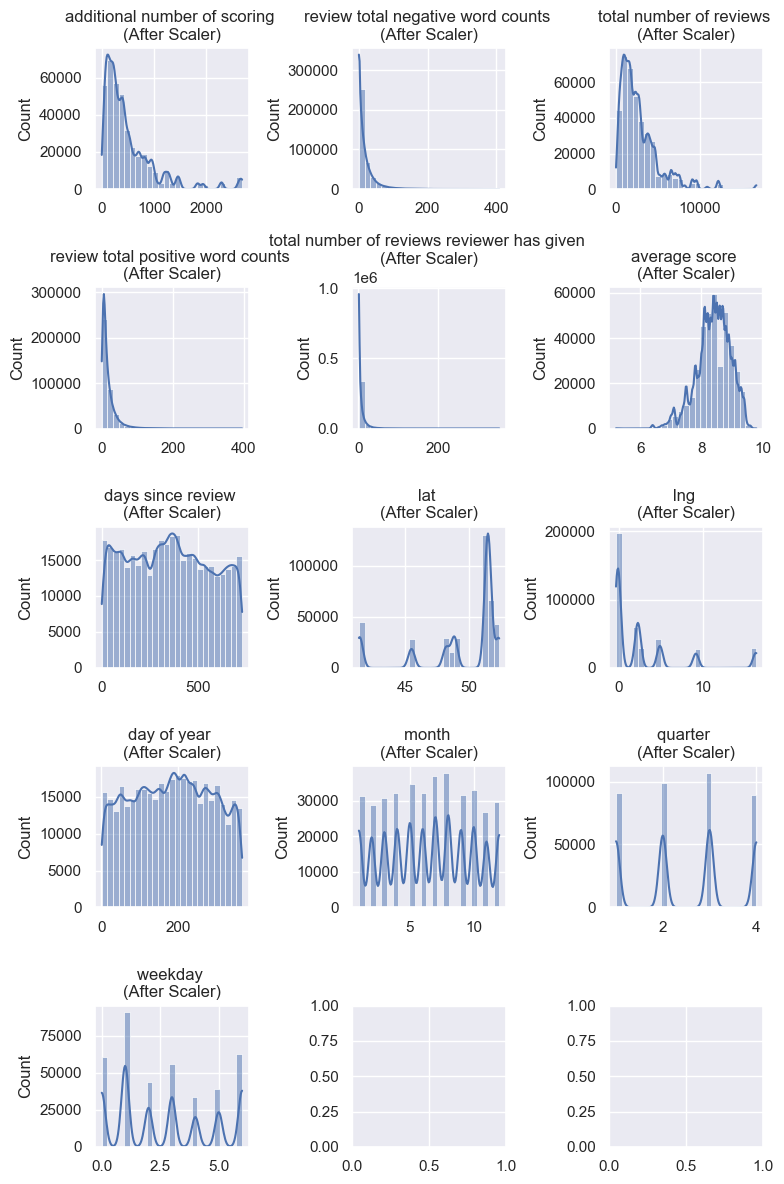

In [22]:
# Отображаем распределение признаков в виде гистограмм
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(8, 12))

Col_list = NumDataHotel_mod.columns.tolist()

for i, j in enumerate(Col_list):
    if i <= 2:
        hist = sns.histplot(data=NumDataHotel_mod[j], legend=False, kde=True, 
                         bins=25, ax=ax[0, i])
    
        hist.set(title=f'{j} \n(After Scaler)'.replace('_', ' '), xlabel='')
        
    elif i <= 5:
        hist = sns.histplot(data=NumDataHotel_mod[j], legend=False, kde=True, 
                         bins=25, ax=ax[1, i-3])
    
        hist.set(title=f'{j} \n(After Scaler)'.replace('_', ' '), xlabel='')
     
    elif i <= 8:
        hist = sns.histplot(data=NumDataHotel_mod[j], legend=False, kde=True, 
                         bins=25, ax=ax[2, i-6])
    
        hist.set(title=f'{j} \n(After Scaler)'.replace('_', ' '), xlabel='')   
        
    elif i <= 11:
        hist = sns.histplot(data=NumDataHotel_mod[j], legend=False, kde=True, 
                         bins=25, ax=ax[3, i-9])
    
        hist.set(title=f'{j} \n(After Scaler)'.replace('_', ' '), xlabel='')   
    
    else:
        hist = sns.histplot(data=NumDataHotel_mod[j], legend=False, kde=True, 
                         bins=25, ax=ax[4, i-12])
    
        hist.set(title=f'{j} \n(After Scaler)'.replace('_', ' '), xlabel='') 

fig.tight_layout()
fig.show()

In [23]:
# Обединяем преобразованные признаки в единый датафрейм
HotelsDataTransformed = pd.concat([NumDataHotel_mod, ObjDataHotel_final, year_dummie], axis=1)

HotelsDataTransformed

,additional_number_of_scoring,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,average_score,days_since_review,lat,lng,day_of_year,...,couple,mobile_submit,reviewer_nationality_2,United Kingdom,Spain,Austria,room_type_5,year_2015,year_2016,year_2017
0,581,3,1994,4,7,8.4,531,51.507894,-0.143671,50,...,1,1,0,1,0,0,0,0,1,0
1,299,3,1361,2,14,8.3,203,51.521009,-0.123097,12,...,1,0,0,1,0,0,0,0,0,1
2,32,6,406,0,14,8.9,289,48.845377,2.325643,292,...,0,1,0,0,0,0,0,0,1,0
3,34,0,607,11,8,7.5,681,48.888697,2.394540,265,...,0,0,0,0,0,0,0,1,0,0
4,914,4,7586,20,10,8.5,516,52.385601,4.847060,65,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,107,0,617,10,10,9.0,106,51.494028,-0.191050,109,...,0,1,0,1,0,0,0,0,0,1
386799,272,0,3224,93,1,8.4,171,48.192379,16.399451,44,...,1,1,1,0,0,1,0,0,0,1
386800,457,12,2751,9,21,6.8,543,51.520795,-0.131084,38,...,0,0,0,1,0,0,0,0,1,0
386801,365,0,1567,6,28,8.1,74,51.515125,-0.160066,141,...,0,0,0,1,0,0,0,0,0,1


# Оцениваем корреляцию признаков

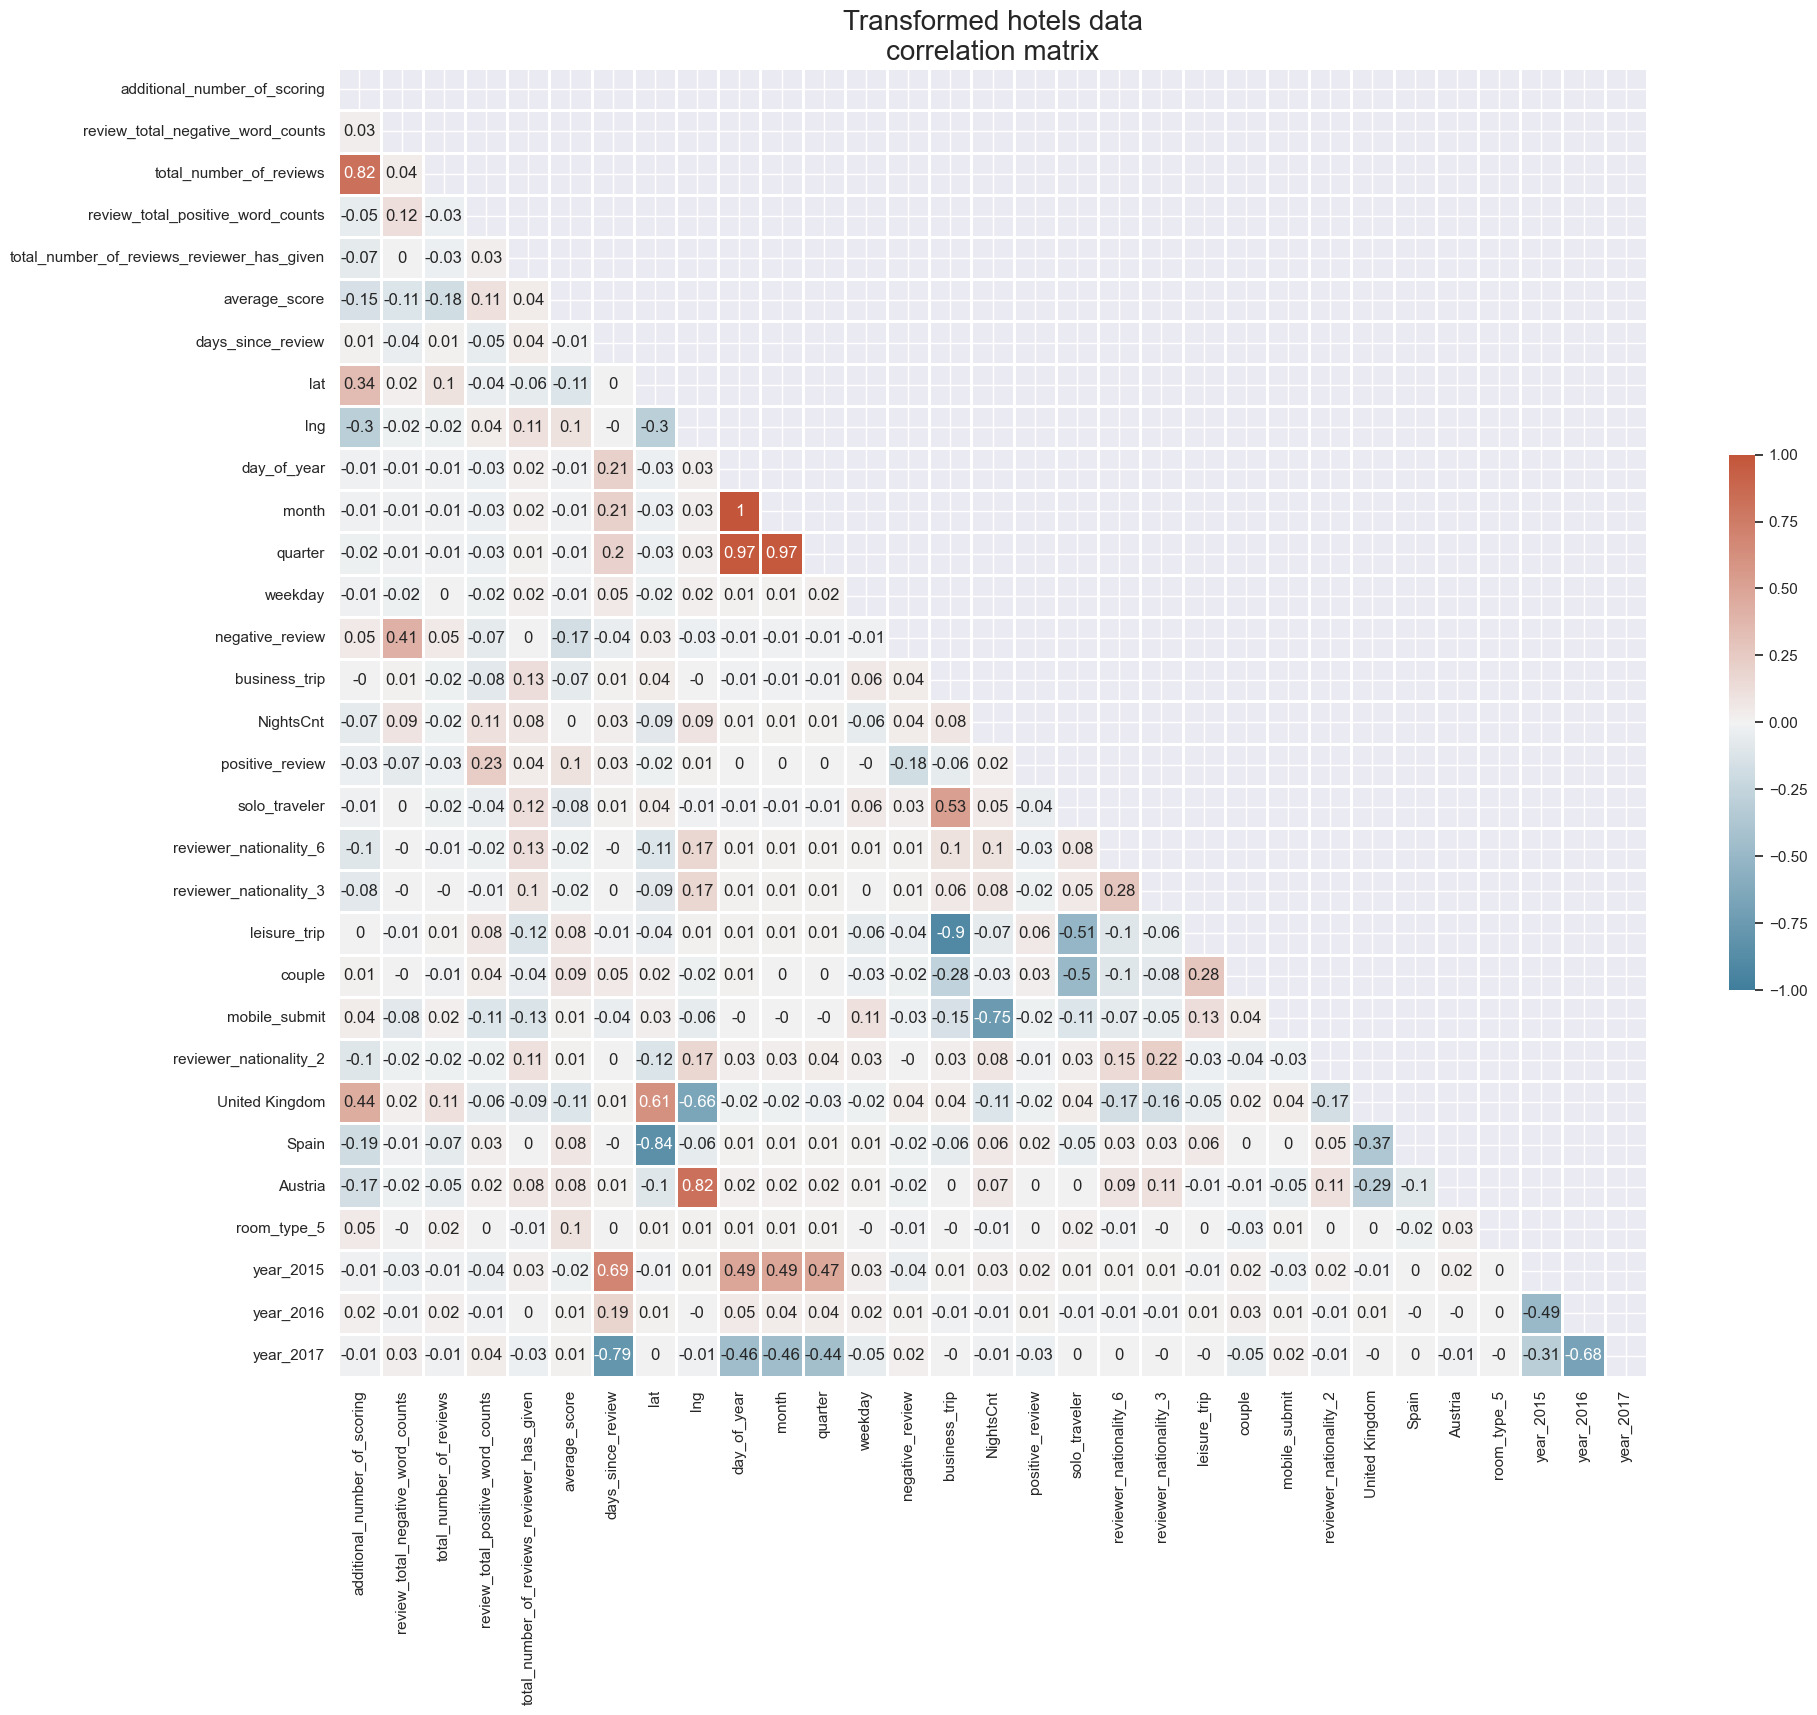

In [24]:
# Генерируем корреляционную матрицу
corr_mat = HotelsDataTransformed.corr(numeric_only=True)
corr_mat

# Создаем маску которая позволит убрать верхний треугольник
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# Генерируем тепловую карту корреляций
fig, ax = plt.subplots()

fig.set_size_inches(20, 20)

cmap=sns.diverging_palette(230,  20, as_cmap=True)

CorrHeatmap = sns.heatmap(data=round(corr_mat, 2), mask=mask, 
            cmap=cmap, square=True, linewidths=0.75, 
            vmin=-1, vmax=1, annot=True, cbar_kws={'shrink': 0.3})

CorrHeatmap.set_title('Transformed hotels data\ncorrelation matrix', 
                      fontdict={'size':20})
fig.tight_layout()
################################################################################




business_trip       -0.904145
leisure_trip        -0.904145
Spain               -0.844762
lat                 -0.844762
days_since_review   -0.791438
year_2017           -0.791438
mobile_submit       -0.748588
NightsCnt           -0.748588
dtype: float64

additional_number_of_scoring    0.824467
total_number_of_reviews         0.824467
lng                             0.824821
Austria                         0.824821
quarter                         0.969829
day_of_year                     0.996225
month                           0.996225
dtype: float64

['business_trip',
 'leisure_trip',
 'Spain',
 'lat',
 'days_since_review',
 'year_2017',
 'mobile_submit',
 'NightsCnt',
 'additional_number_of_scoring',
 'total_number_of_reviews',
 'lng',
 'Austria',
 'quarter',
 'day_of_year',
 'month']

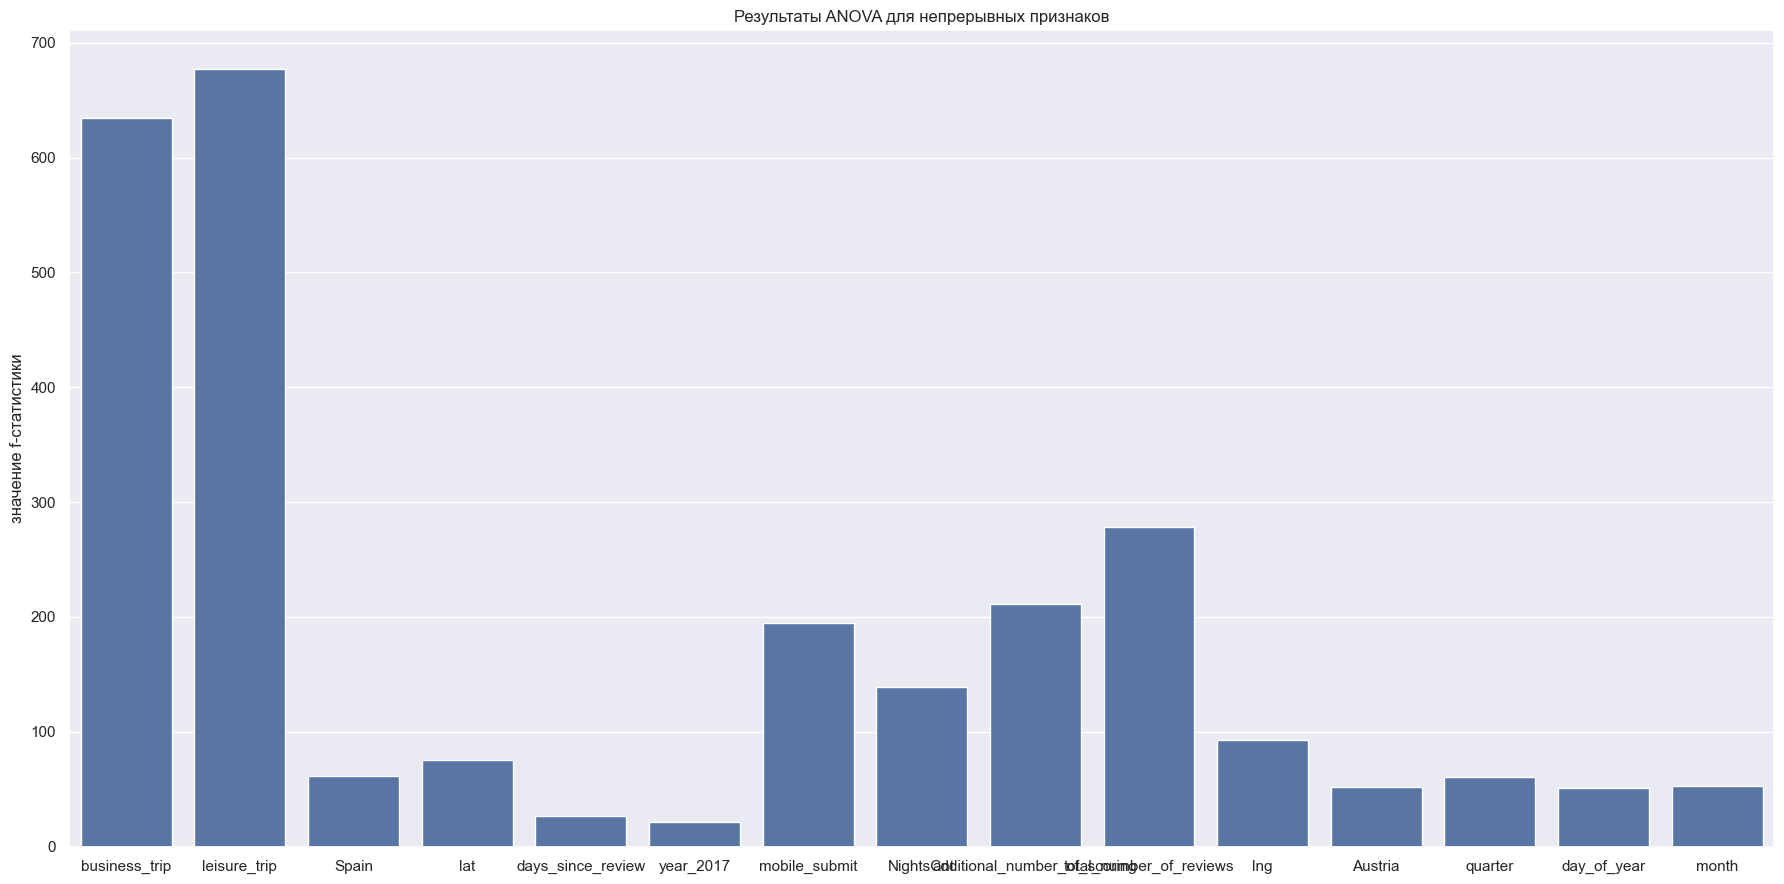

In [25]:
# Определяем пары с уровнем коэффициента корреляциии -0.7 или ниже
high_neg_corr = corr_mat.min().sort_values()
high_neg_corr = high_neg_corr[high_neg_corr <= -0.7]
display(high_neg_corr)

# business_trip = leisure_trip
###############################################################################


# Определяем пары с уровнем коэффициента корреляциии 0.7 или выше
corr_mat = corr_mat[corr_mat != 1]
high_pos_corr = corr_mat.max()
high_pos_corr = high_pos_corr[high_pos_corr >= 0.7].sort_values()
display(high_pos_corr)

# additional_number_of_scoring = total_number_of_reviews
###############################################################################

corr_index = list(high_neg_corr.index) + list(high_pos_corr.index)


from sklearn.feature_selection import f_classif


y = hotels_data['reviewer_score'].astype('int')



f_classif_data = HotelsDataTransformed[corr_index]

imp_num = pd.Series(f_classif(f_classif_data, y)[0], index = list(f_classif_data))
imp_num.sort_values(inplace = True)



fig, ax = plt.subplots( figsize=(18, 9))
BarPl = sns.barplot(x=imp_num.index, 
                    y=imp_num.values, ax=ax, order=corr_index)

BarPl.set(title='Результаты ANOVA для непрерывных признаков',
          xlabel='', ylabel='значение f-статистики' )



fig.tight_layout()
fig.show()



display(corr_index)

In [26]:
# Удаляем признаки из сильно скоррелированных пар которые оказывают меньшее воздействие на целевую переменную, 
HotelsDataFinal = HotelsDataTransformed.drop(['business_trip', 'Spain', 'day_of_year',
                                              'NightsCnt', 'Austria', 'month',
                                              'additional_number_of_scoring', 'year_2017'], 
                                             axis=1)
HotelsDataFinal

,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,average_score,days_since_review,lat,lng,quarter,weekday,...,reviewer_nationality_6,reviewer_nationality_3,leisure_trip,couple,mobile_submit,reviewer_nationality_2,United Kingdom,room_type_5,year_2015,year_2016
0,3,1994,4,7,8.4,531,51.507894,-0.143671,1,4,...,0,0,1,1,1,0,1,0,0,1
1,3,1361,2,14,8.3,203,51.521009,-0.123097,1,3,...,0,0,0,1,0,0,1,0,0,0
2,6,406,0,14,8.9,289,48.845377,2.325643,4,1,...,1,0,1,0,1,0,0,0,0,1
3,0,607,11,8,7.5,681,48.888697,2.394540,3,1,...,0,0,1,0,0,0,0,0,1,0
4,4,7586,20,10,8.5,516,52.385601,4.847060,1,5,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,0,617,10,10,9.0,106,51.494028,-0.191050,2,2,...,0,0,1,0,1,0,1,0,0,0
386799,0,3224,93,1,8.4,171,48.192379,16.399451,1,0,...,1,0,1,1,1,1,0,0,0,0
386800,12,2751,9,21,6.8,543,51.520795,-0.131084,1,6,...,1,0,0,0,0,0,1,0,0,1
386801,0,1567,6,28,8.1,74,51.515125,-0.160066,2,6,...,0,0,1,0,0,0,1,0,0,0


In [28]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = HotelsDataFinal
y = hotels_data['reviewer_score'] 

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  



# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred):.4f}')

MAPE: 0.1334


<Axes: >

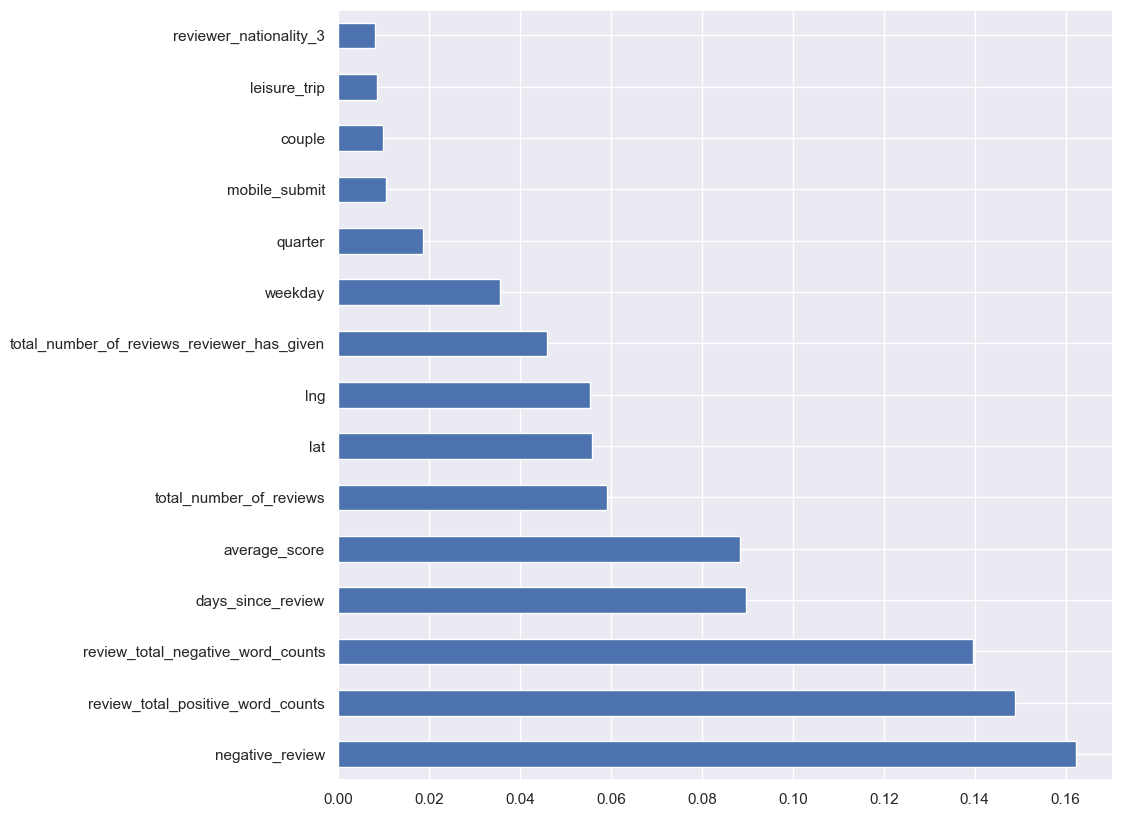

In [ ]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')